In [474]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

In [475]:
class FunctionMinimizationEnv(gym.Env):
    def __init__(self, max_step=100, patience=10):
        super().__init__()
        self.param_dim = 1  # Example: 1 parameter
        self.action_space_limit = [-1, 1]
        self.action_space = spaces.Box(
            low=self.action_space_limit[0],
            high=self.action_space_limit[1],
            shape=(self.param_dim,),
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.param_dim,), dtype=np.float32
        )
        self.state = np.zeros(self.param_dim, dtype=np.float32)
        self.count = 0
        self.global_value = float("inf")
        self.max_step = max_step
        self.patience = patience
        self.patience_remaining = patience

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.random.uniform(-10, 10, size=(self.param_dim,))
        # self.state = np.array([10], dtype=np.float32)  # Fixed start
        self.count = 0
        self.global_value = self.target_function(self.state)
        self.patience_remaining = self.patience
        # Gymnasium reset returns (obs, info)
        return self.state, {}

    def step(self, action):
        action = np.asarray(action, dtype=np.float32)
        action = np.clip(action, self.action_space_limit[0], self.action_space_limit[1])
        self.state = self.state + action
        value = self.target_function(self.state)
        reward = self.global_value - value  # Positive reward for improvement
        if reward > 0:  # Improvement found
            self.global_value = value  # Update global best
            self.patience_remaining = self.patience  # Reset patience
        else:  # No improvement
            self.patience_remaining -= 1

        self.count += 1
        if self.patience_remaining <= 0 or self.count >= self.max_step:
            terminated = True
        else:
            terminated = False
        truncated = False
        info = {
            "action": action,
            "state": self.state,
            "value": value,
            "global_value": self.global_value,
            "reward": reward,
            "steps": self.count,
            "patience_remaining": self.patience_remaining,
        }
        # Gymnasium step returns (obs, reward, terminated, truncated, info)
        return self.state, reward, terminated, truncated, info

    def target_function(self, x):
        return np.sum(x**2)  # Example: minimize sum of squares

In [476]:
from stable_baselines3 import SAC

env = FunctionMinimizationEnv(patience=20, max_step=500)
model = SAC("MlpPolicy", env, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [477]:
model.learn(total_timesteps=1000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.5     |
|    ep_rew_mean     | -579     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 132      |
|    time_elapsed    | 1        |
|    total_timesteps | 154      |
| train/             |          |
|    actor_loss      | 15.4     |
|    critic_loss     | 191      |
|    ent_coef        | 0.984    |
|    ent_coef_loss   | -0.0261  |
|    learning_rate   | 0.0003   |
|    n_updates       | 53       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 42.6     |
|    ep_rew_mean     | -292     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 70       |
|    time_elapsed    | 4        |
|    total_timesteps | 341      |
| train/             |          |
|    actor_loss      | 13.2     |
|    critic_loss     | 120      |
|    ent_coef 

,action,state,value,global_value,reward,steps,patience_remaining
0,[0.98634386],[-6.4087027992821195],41.071472,41.071472,13.615244,1,20
28,[0.0],[-0.13198352714543127],0.017420,0.015969,-0.001451,29,0


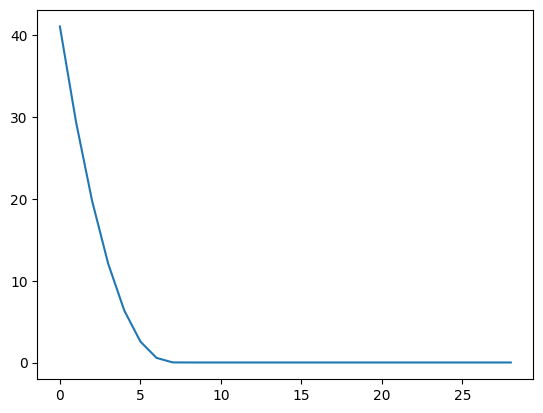

In [478]:
import pandas as pd

obs, info = env.reset()
terminated = False
truncated = False

data = []
while not (terminated or truncated):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    data.append(info)

df = pd.DataFrame.from_dict(data)
df.global_value.plot()
display(df.iloc[[0, -1], :])

In [479]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(
    model,
    env,
    n_eval_episodes=100,  # Number of episodes to run for evaluation
    deterministic=True,  # Use deterministic actions for evaluation
    render=False,  # Set to True if you want to visualize the agent
)

print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

c:\Users\admin\Coding\research\rl-meta-test\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: 34.21 +/- 31.17
